In [0]:
import pandas as pd
import numpy as np
import sklearn
import nltk
import keras
import string as st
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from google.colab import files
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt


***Run the code in google colab.***

# ***Neural Machine Translation from french to english using encoder decoder sequence model.***


# ***For previous submission, dataset was set to 350000 records.For this,it is restricted to 60000 records apporx. for this execution (total dataset is of 174481 records).***

I have generated the output in the csv file 'predicted.csv' which will be visible in the left pane on refreshing.

In [2]:
# convert data into dataframe  
data = pd.read_csv('fra.txt', delimiter='\t', names=['English', 'French'], usecols=[0,1])
dataCopy=data
data.head()

,English,French
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [0]:
data.shape
# restrict dataset to 60000 records
dataLimit = np.random.rand(len(dataCopy)) <= 0.35
limitDataset=dataCopy[dataLimit]

In [4]:
limitDataset.shape

(60670, 2)

In [5]:
#keras based tokenizer is used to map words to integer
tokenizerEn=Tokenizer()
tokenizerFr=Tokenizer()

tokenizerEn.fit_on_texts(limitDataset['English'].to_numpy())
vocabSizeEn = len(tokenizerEn.word_index) + 1

tokenizerFr.fit_on_texts(limitDataset['French'].to_numpy())
vocabSizeFr = len(tokenizerFr.word_index) + 1

print('Vocabulary Size: English ', vocabSizeEn, "French ", vocabSizeFr)

Vocabulary Size: English  10051 French  19512


In [6]:
#Data preprocessing to clean the data and get the maximum sized length of sentences from both languages
maxLenEn = 0
maxLenFr = 0
for index, row in limitDataset.iterrows():
    row['English']=row['English'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['English'].split())>maxLenEn:
        maxLenEn=len(row['English'].split())
    row['French']=row['French'].translate(str.maketrans('', '', st.punctuation)).lower()
    if len(row['French'].split())>maxLenFr:
        maxLenFr=len(row['French'].split())  
print("Maximum sized length : English ",maxLenEn,"French ", maxLenFr )

Maximum sized length : English  47 French  51


In [7]:
# we will split the data to keep 70:30 ratio for training and test data
splitData = np.random.rand(len(limitDataset)) <= 0.7
trainData = limitDataset[splitData]
testData = limitDataset[~splitData]
#check the data count in training set and test set
print("Training Data: ",trainData.shape," Test data: ",testData.shape)
# Data in to numpy array conversion
trainDataNP=trainData.to_numpy()
testDataNP=testData.to_numpy()

Training Data:  (42534, 2)  Test data:  (18136, 2)


**Data encoding is done i.e. converting text to ids and add padding to make all sequences of same length. **

In [0]:
def dataEncoder(allData, lanTokenizer, length):
    encodedData = lanTokenizer.texts_to_sequences(allData)
    paddedData = pad_sequences(encodedData, maxlen=length, padding='post')
    return paddedData

trainFr = dataEncoder(trainDataNP[:, 1],tokenizerFr,maxLenFr)
trainEn = dataEncoder(trainDataNP[:, 0],tokenizerEn,maxLenEn)
testFr = dataEncoder(testDataNP[:, 1],tokenizerFr,maxLenFr)
testEn = dataEncoder(testDataNP[:, 0],tokenizerEn,maxLenEn)

In [9]:
print(trainFr.shape, testFr.shape)

(42534, 51) (18136, 51)


In [10]:
#Sequence model
def sequenceModel(vocabFr, vocabEn, maxFr, maxEn, units):
    seqModel = Sequential()
    seqModel.add(Embedding(vocabFr, units, input_length=maxFr, mask_zero=True))
    seqModel.add(LSTM(units))
    seqModel.add(RepeatVector(maxEn))
    seqModel.add(LSTM(units, return_sequences=True))
    seqModel.add(Dense(vocabEn, activation='softmax'))
    return seqModel

seqModel = sequenceModel(vocabSizeFr, vocabSizeEn, maxLenFr, maxLenEn, 256)
rmsOptimizer = optimizers.RMSprop(lr=0.01)
seqModel.compile(optimizer=rmsOptimizer, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [11]:
modelPrediction = seqModel.fit(trainFr, trainEn.reshape(trainEn.shape[0], trainEn.shape[1], 1),epochs=15, batch_size=256, validation_split = 0.2, verbose=1)




Train on 34027 samples, validate on 8507 samples
Epoch 1/15





34027/34027 [==============================] - 240s 7ms/step - loss: 0.9437 - val_loss: 1.4030
Epoch 2/15
34027/34027 [==============================] - 227s 7ms/step - loss: 0.6145 - val_loss: 1.4359
Epoch 3/15
34027/34027 [==============================] - 224s 7ms/step - loss: 0.5093 - val_loss: 1.3170
Epoch 4/15
34027/34027 [==============================] - 238s 7ms/step - loss: 0.4324 - val_loss: 1.3289
Epoch 5/15
34027/34027 [==============================] - 235s 7ms/step - loss: 0.3731 - val_loss: 1.3369
Epoch 6/15
34027/34027 [==============================] - 246s 7ms/step - loss: 0.3256 - val_loss: 1.3718
Epoch 7/15
34027/34027 [==============================] - 245s 7ms/step - loss: 0.2866 - val_loss: 1.3760
Epoch 8/15
34027/34027 [==============================] - 244s 7ms/step - loss: 0.2548 - val_loss: 1.4794
Epoch 9/15
34027/34027 [==============================] - 247s 7ms/step - loss: 0.2285 - val_lo

In [0]:
#Get predictions for text data 
testPrediction = seqModel.predict_classes(testFr.reshape((testFr.shape[0],testFr.shape[1])))

In [0]:
## data decoder Convert mapped words in to normal words
def wordConversion(word_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == word_index:
            return word
    return None
    
def dataDecoder(prediction):
    textPredicted=list()
    for sentence in prediction:
        sentenceConverted = list()
        for word_index in range(len(sentence)):
            word = wordConversion(sentence[word_index], tokenizerEn)
            if word_index > 0:
                if (word == wordConversion(sentence[word_index-1], tokenizerEn)) or (word == None):
                    sentenceConverted.append('')
                else:
                    sentenceConverted.append(word)

            else:
                if(word == None):
                    sentenceConverted.append('')
                else:
                    sentenceConverted.append(word)            

        textPredicted.append(' '.join(sentenceConverted))
        
    return textPredicted

In [0]:
#calling data decoder for the predictions
predictedText = dataDecoder(testPrediction)
predictedDataframe = pd.DataFrame({'French text': testData['French'],' Expected text' : testData['English'], 'Predicted text' : predictedText})

# ***Data after conversion from french to english i.e. both the expected and predicted english text***

In [15]:

predictedDataframe.head(10)

,French text,Expected text,Predicted text
0,va,go,go yourself ...
10,ça suffit,stop,it
30,merci,cheers,thanks and for me ...
41,monte,hop in,you are other ...
64,en aucune manière,no way,i it of ...
83,soyez justes,be fair,be beautiful ...
101,entre,come in,come on ...
114,sortez,get out,take of ...
118,pars,go away,go away ...
126,allezvous en,go away,lets you coming ...


# ***Using corpus bleu function to calculate the Bleu score for data***

In [16]:
print('BLEU score using corpus bleu function:',corpus_bleu(testDataNP[:,0], predictedText))

BLEU score using corpus bleu function: 0.6228368827623536


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## ***Ploting training and validation losses***



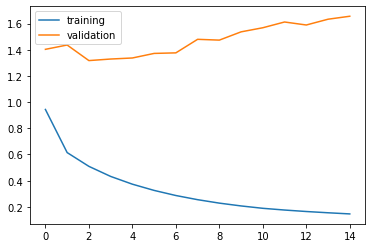

In [24]:
plt.plot(modelPrediction.history['loss'])
plt.plot(modelPrediction.history['val_loss'])
plt.legend(['training','validation'])
plt.show()